                 num                      date_time  electricity_usage_kWh  \
count  122400.000000                         122400          122400.000000   
mean       30.500000  2020-07-13 11:30:00.000000256            2324.830866   
min         1.000000            2020-06-01 00:00:00               0.000000   
25%        15.750000            2020-06-22 05:45:00            1055.268000   
50%        30.500000            2020-07-13 11:30:00            1700.352000   
75%        45.250000            2020-08-03 17:15:00            2780.487000   
max        60.000000            2020-08-24 23:00:00           17739.225000   
std        17.318173                            NaN            2058.999326   

       temperature_C  wind_speed_m_s  humidity_percent  precipitation_mm  \
count  122400.000000   122400.000000     122400.000000     122400.000000   
mean       24.251713        2.151641         80.169848          0.514989   
min        11.100000        0.000000         19.000000          0.000

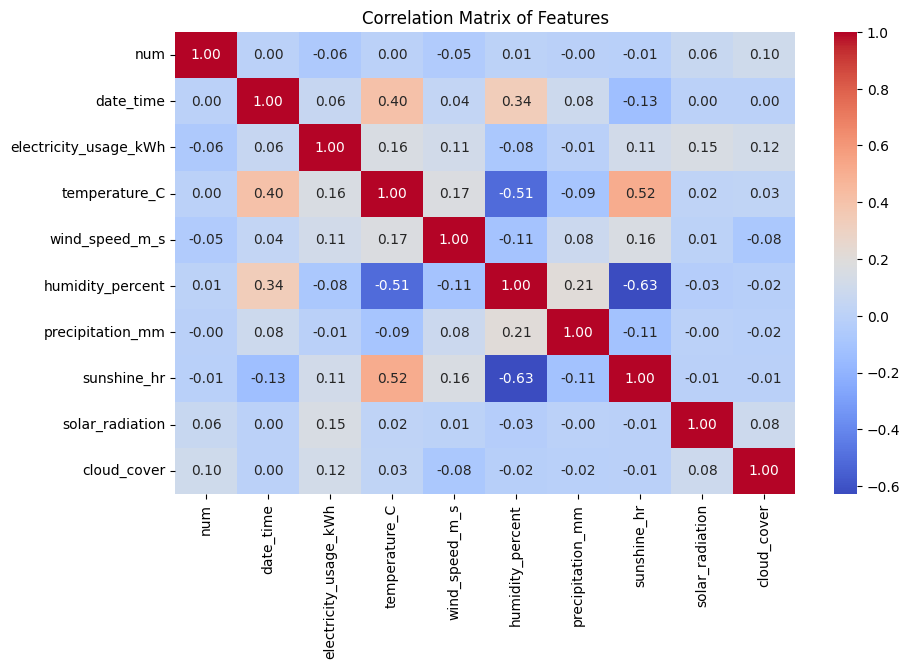

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기
train_data_path = 'train.csv'
test_data_path = 'test.csv'

# 다른 인코딩으로 데이터 로드
train_df = pd.read_csv(train_data_path, encoding='ISO-8859-1')
train_df.columns = ['num', 'date_time', 'electricity_usage_kWh', 'temperature_C', 'wind_speed_m_s', 'humidity_percent', 'precipitation_mm', 'sunshine_hr', 'solar_radiation', 'cloud_cover']

# 2. 날짜 데이터 변환
train_df['date_time'] = pd.to_datetime(train_df['date_time'])

# 3. 데이터 통계 요약 출력
train_stats = train_df.describe()
print(train_stats)

# 4. 상관관계 분석 및 시각화
corr_matrix = train_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix of Features')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from tqdm import tqdm
import time
import os

# 1. 데이터 로드 및 전처리
train_data_path = 'train.csv'

# train 데이터 로드
train_df = pd.read_csv(train_data_path, encoding='ISO-8859-1')
train_df.columns = ['num', 'date_time', 'electricity_usage_kWh', 'temperature_C', 'wind_speed_m_s', 'humidity_percent', 'precipitation_mm', 'sunshine_hr', 'solar_radiation', 'cloud_cover']

# 특징과 레이블 선택
X = train_df[['temperature_C', 'wind_speed_m_s', 'humidity_percent', 'precipitation_mm', 'sunshine_hr']].fillna(0).values
y = train_df['electricity_usage_kWh'].values

# KMeans 클러스터링을 통해 파생변수 생성
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# 원래 데이터에 클러스터 레이블 추가
X_extended = pd.concat([pd.DataFrame(X), pd.DataFrame(cluster_labels, columns=['cluster'])], axis=1).values

# 데이터 정규화 (RobustScaler 사용)
scaler = RobustScaler()
X_extended[:, :-1] = scaler.fit_transform(X_extended[:, :-1])  # 클러스터 레이블 제외하고 정규화

# 데이터를 텐서로 변환
X_tensor = torch.tensor(X_extended, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# DNN 회귀 모델 정의
class DNNRegression(nn.Module):
    def __init__(self):
        super(DNNRegression, self).__init__()
        self.layer1 = nn.Linear(X_extended.shape[1], 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 256)
        self.layer4 = nn.Linear(256, 128)
        self.layer5 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 1)
        self._initialize_weights()

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = torch.relu(self.layer5(x))
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# 하이퍼파라미터 설정
learning_rate = 0.01  # 러닝 레이트를 0.01로 설정
num_epochs = 10
batch_size = 64

# K-Fold 교차 검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# 학습 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
valid_losses = []

for train_index, val_index in kf.split(X_tensor):
    X_train_fold, X_valid_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_valid_fold = y_tensor[train_index], y_tensor[val_index]

    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = DNNRegression().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 학습 시간 측정 시작
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 예측값 계산
            predictions = model(batch_X)

            # 손실 계산
            loss = criterion(predictions, batch_y)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 역전파 및 가중치 갱신
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f'Fold {fold}, Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

        # 평가 손실 계산
        model.eval()
        with torch.no_grad():
            X_valid_fold, y_valid_fold = X_valid_fold.to(device), y_valid_fold.to(device)
            val_predictions = model(X_valid_fold)
            val_loss = criterion(val_predictions, y_valid_fold)

        print(f'Fold {fold}, Valid Loss: {val_loss.item():.4f}')

    # 모델 저장 및 fold 결과 기록
    torch.save(model.state_dict(), f"best_model_fold_{fold}.pth")
    valid_losses.append(val_loss.item())
    fold += 1

# K-Fold 검증 결과 출력
print(f"K-Fold 검증 손실: {valid_losses}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Fold 1, Epoch [1/10], Loss: 4307287.6701
Fold 1, Valid Loss: 4238513.5000
Fold 1, Epoch [2/10], Loss: 4130909.6239
Fold 1, Valid Loss: 4156221.5000
Fold 1, Epoch [3/10], Loss: 4088339.3013
Fold 1, Valid Loss: 4066034.0000
Fold 1, Epoch [4/10], Loss: 4058781.9189
Fold 1, Valid Loss: 4066519.5000
Fold 1, Epoch [5/10], Loss: 4043188.7114
Fold 1, Valid Loss: 4054819.5000


In [ ]:
'''
전력 사용량 예측을 위해 DNN을 사용하고, K-Fold 교차 검증을 통해 과적합을 방지하며 모델의 일반화 성능을 높이려 했습니다.
RobustScaler로 데이터를 정규화해 이상치의 영향을 줄였고, KMeans 클러스터링으로 파생 변수를 추가해 데이터의 패턴을 더 잘 학습하도록 했습니다.
Adam 옵티마이저는 빠르고 안정적인 학습을 위해 사용되었으며, 각 폴드에서 최적의 모델을 저장해 성능을 평가했습니다.
'''